# LLM Inference Pipeline

This notebook implements the LLM inference pipeline described in `pipeline_spec.md`.

Sections:
- Setup & installs
- Parse and validate spec
- Tokenizer & Model loader
- Prompt construction
- Dataset loading & sampling
- Batched inference & streaming generator
- Extraction, metrics, and plotting
- Demo runs and simple tests


In [1]:
# Setup: Install dependencies and import packages

# If running in binder or a fresh environment you may need to install packages.
# Use `%pip install` to ensure installs are available in the notebook kernel.

# Uncomment and run if you need to install packages
# %pip install -q transformers accelerate torch pandas matplotlib seaborn datasets evaluate tqdm regex sentencepiece

import os
import json
import re
from dataclasses import dataclass, asdict
from typing import List, Optional, Dict, Any, Tuple
import logging
import random
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Try importing transformers and torch and give friendly guidance if missing
try:
    import torch
    from transformers import (
        AutoTokenizer,
        AutoModelForCausalLM,
        pipeline,
        logging as hf_logging,
    )
except Exception as e:
    raise RuntimeError(
        "Transformers or Torch not available in the kernel. Please run the install cell: `%pip install transformers torch`"
    ) from e

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
hf_logging.set_verbosity_error()

# Device detection
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.mps.is_available() else "cpu"
)
logger.info(f"Using device: {DEVICE}")

# Reproducible seeds
DEFAULT_SEED = 42
random.seed(DEFAULT_SEED)
torch.manual_seed(DEFAULT_SEED)

# Default paths / constants
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "datasets"
PIPELINE_SPEC = PROJECT_ROOT / "pipeline_spec.md"
DEFAULT_MODEL = (
    "Qwen/Qwen2.5-0.5B-Instruct"  # per spec; we will fallback if unavailable
)

INFO:root:Using device: cuda


In [2]:
from dataclasses import dataclass

@dataclass
class PipelineSpec:
    default_model: str = DEFAULT_MODEL
    tokenizer_context_length: int = 2048

    classification_system_prompt: str = (
        "You are a news trustworthiness classifier.\n"
        "Classify an ARTICLE as:\n"
        "1 = trustworthy (neutral, fact-focused reporting with attribution; wire-service style; avoids conspiratorial framing)\n"
        "0 = untrustworthy (opinion/propaganda, sensational or conspiratorial claims without evidence, ad hominem insults, heavy partisan framing, or manipulative rhetoric).\n"
        "Do NOT judge by whether the topic is controversial. Judge by reporting quality and style.\n"
        "If it reads like a blog/opinion piece or uses loaded language, it is likely 0.\n"
        "If it reads like Reuters/AP-style reporting with named sources and neutral tone, it is likely 1.\n"
        "Output exactly one token: 0 or 1.\n\n"
        "Examples:\n"
        "ARTICLE: (Reuters) - A populist politician whose party could emerge as a kingmaker at this month s New Zealand election has called for an inquiry into whether a member of the ruling National Party government has been working for China s intelligence services. Earlier this week the Financial Times reported that National Party member Jian Yang spent a decade at elite Chinese military academies and has been under investigation by New Zealand s national intelligence agency. Winston Peters... Labour leader Jacinda Ardern declined to comment...\n"
        "LABEL: 1\n\n"
        "ARTICLE: After examining the data Reuters used to make their bold prediction, we noticed they hadn t given any consideration to the high probability that Democrats will likely find a way to give illegal aliens the opportunity to cast their ballots in 2016... (highly partisan framing; accusations; blog tone)\n"
        "LABEL: 0\n\n"
        "ARTICLE: SHANGHAI (Reuters) - Chinese state media warned U.S. President-elect Donald Trump on Saturday against flip-flopping on trade deals in Asia... Xinhua said... leaders gathered... (neutral wire reporting with attribution)\n"
        "LABEL: 1\n\n"
        "ARTICLE: NAIROBI (Reuters) - Kenyan police fired teargas at more than 1,000 opposition supporters marching through the capital Nairobi on Wednesday to demand election reforms, a Reuters witness said... (straight factual reporting)\n"
        "LABEL: 1\n\n"
        "ARTICLE: This is great and so wonderful to see the positive events pushing back on the Obama policies... Everyone knows the Iran deal is a stinker... Trump and Cruz hummm... (opinionated, loaded language)\n"
        "LABEL: 0\n\n"
        "ARTICLE: BUENOS AIRES (Reuters) - The victory of Argentine President Mauricio Macri s coalition in midterm elections... analysts say... polls said... (neutral reporting)\n"
        "LABEL: 1\n\n"
        "ARTICLE: Florida Senator Marco Rubio actually knows something the rest of us know for once... human stegosaurus... singularly horrible... (ad hominem + editorial tone)\n"
        "LABEL: 0\n\n"
        "ARTICLE: This announcement seems to indicate that the Obama regime already knows Hillary is going to be walking away unscathed... cover up... Joe the Clown... (conspiratorial framing + insults)\n"
        "LABEL: 0\n\n"
        "ARTICLE: MEDELLIN, Colombia (Reuters) - Pope Francis on Saturday visited Medellin... asked that God convert the hearts of the drug assassins... (neutral reporting)\n"
        "LABEL: 1\n\n"
        "ARTICLE: (Reuters) - A committee of Kansas lawmakers will be charged with reconciling differences in legislation... Moody’s and S&P said... (neutral reporting)\n"
        "LABEL: 1\n\n"
        "Now classify the next article.\n"
    )

    user_template: str = "ARTICLE: {article}\nLABEL:"
pipeline_spec = PipelineSpec()

In [3]:
# Cache util
class SimpleCache:
    def __init__(self):
        self._cache = {}

    def get(self, key):
        return self._cache.get(key)

    def set(self, key, value):
        self._cache[key] = value


cache = SimpleCache()

In [4]:
# Model loader: device placement, caching, and smoke tests


def load_model(
    model_name: str, device: str = DEVICE, dtype: Optional[torch.dtype] = None
):
    """Load a causal LM model with graceful fallback.

    Returns: (model, tokenizer)
    """
    # Check cache
    cache_key = f"model::{model_name}::device::{device}"
    cached_model = cache.get(cache_key)
    if cached_model is not None:
        logger.info(f"Using cached model for {model_name}")
        return cached_model

    try:
        model = AutoModelForCausalLM.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        # Add pad token if missing
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<|pad|>"})
            model.resize_token_embeddings(len(tokenizer))
        model.to(device)
        model.eval()
        cache.set(cache_key, (model, tokenizer))
        logger.info(f"Loaded model {model_name} to {device}")
        return model, tokenizer
    except Exception as e:
        logger.warning(f"Failed to load model {model_name}: {e}")
        raise


model, tokenizer = load_model(pipeline_spec.default_model)

INFO:root:Loaded model Qwen/Qwen2.5-0.5B-Instruct to cuda


In [5]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [6]:
# Prompt templates and preprocessing

SYSTEM_PROMPT = pipeline_spec.classification_system_prompt
USER_TEMPLATE = pipeline_spec.user_template


def make_prompts(
    articles: list[str] | pd.Series,
    system: str = SYSTEM_PROMPT,
    user_template: str = USER_TEMPLATE,
    prefilled=False,
) -> list[list[dict[str, str]]]:
    """
    Given a batch of articles (a list), returns a batch of formatted prompts.
    Each prompt is a list of dicts.
    Each dict contains role and content information.
    The system prompt contains generic classification instructions.
    The user content contains the article to be classified.
    Optionally, we prefill the model response to guide classification output.
    """
    # check that the articles are of the right type
    if type(articles) is not list and type(articles) is not pd.Series:
        raise ValueError(
            f"`articles` needs to be a list of strings. Got {type(articles)} instead."
        )

    messages_batch = []
    for article in articles:
        user_text = user_template.format(article=article)
        messages = [
            # {"role": "system", "content": system},
            {"role": "user", "content": system + user_text + "\n CLASSIFICATION (0 or 1):"},
        ]
        if prefilled:
            messages.append(
                {"role": "assistant", "content": "CLASSIFICATION (0 or 1):"},
            )
        messages_batch.append(messages)
    return messages_batch


def encode_prompts(prompts: list[list[dict[str, str]]], tokenizer):
    """
    Given a batch of formatted prompts, returns a batch of tokenized prompts.
    """
    prompts = [
        tokenizer.apply_chat_template(p, tokenize=False, add_generation_prompt=True)
        for p in prompts
    ]
    return tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=pipeline_spec.tokenizer_context_length,
    )


def display_prompt(prompts: list[dict]) -> None:
    """
    Given a batch of (untokenized) prompts, pretty prints the first one.
    """
    for line in prompts[0]:
        for k, v in line.items():
            print(f"[{k}]: {v}")


# Example
prompts = ["This is a prompt."]
display_prompt(make_prompts(prompts, prefilled=True))

[role]: user
[content]: You are a news trustworthiness classifier.
Classify an ARTICLE as:
1 = trustworthy (neutral, fact-focused reporting with attribution; wire-service style; avoids conspiratorial framing)
0 = untrustworthy (opinion/propaganda, sensational or conspiratorial claims without evidence, ad hominem insults, heavy partisan framing, or manipulative rhetoric).
Do NOT judge by whether the topic is controversial. Judge by reporting quality and style.
If it reads like a blog/opinion piece or uses loaded language, it is likely 0.
If it reads like Reuters/AP-style reporting with named sources and neutral tone, it is likely 1.
Output exactly one token: 0 or 1.

Examples:
ARTICLE: (Reuters) - A populist politician whose party could emerge as a kingmaker at this month s New Zealand election has called for an inquiry into whether a member of the ruling National Party government has been working for China s intelligence services. Earlier this week the Financial Times reported that Nat

In [7]:
# Dataset loader, sampling, and a small demo dataset
def load_dataset(
    data_dir: Path = DATA_DIR, max_rows: Optional[int] = None, use_seed=True
) -> pd.DataFrame:
    """
    Load dataset by combining `fake.csv` (label 0) and `true.csv` (label 1).
    Returns dataframe with columns "article" and "label".

    Now performs BALANCED sampling across classes.
    """
    fake_path = data_dir / "fake.csv"
    true_path = data_dir / "true.csv"

    rng = DEFAULT_SEED if use_seed else None

    if fake_path.exists() and true_path.exists():
        try:
            fake = pd.read_csv(fake_path)
            true = pd.read_csv(true_path)

            # Try to find an `article` column; fallback to first column
            def get_text_col(df):
                for c in ["article", "text", "content"]:
                    if c in df.columns:
                        return df[c].astype(str)
                return df.iloc[:, 0].astype(str)

            fake_df = pd.DataFrame({"article": get_text_col(fake), "label": 0})
            true_df = pd.DataFrame({"article": get_text_col(true), "label": 1})
            # Determine per-class sample size
            if max_rows is not None:
                per_class = max_rows // 2
            else:
                # take min class size for balance
                per_class = min(len(fake_df), len(true_df))

            # Sample independently from each class
            fake_df = fake_df.sample(
                n=min(per_class, len(fake_df)),
                random_state=rng,
            )

            true_df = true_df.sample(
                n=min(per_class, len(true_df)),
                random_state=rng,
            )

            # Merge + shuffle to avoid label ordering artifacts
            df = pd.concat([fake_df, true_df], ignore_index=True)
            df = df.sample(frac=1.0, random_state=rng).reset_index(drop=True)

            return df

        except Exception as e:
            logger.warning(f"Failed to read CSVs: {e}")

    # Fallback synthetic dataset
    logger.info("Using synthetic demo dataset (small).")
    demo = [
        (
            "Government releases new public health guidelines that are consistent with prior research and expert consensus.",
            1,
        ),
        (
            "Aliens landed on the White House lawn last night, multiple sources confirm",
            0,
        ),
        (
            "Scientific team publishes peer-reviewed article showing new vaccine efficacy.",
            1,
        ),
        (
            "Miracle cure for diabetes discovered in backyard herb; no clinical trials yet",
            0,
        ),
    ]
    df = pd.DataFrame(demo, columns=["article", "label"])

    if max_rows:
        df = df.head(max_rows)

    return df


def sample_k(
    df: pd.DataFrame, k: int, mode: str = "random", seed: Optional[int] = None
) -> pd.DataFrame:
    if seed is None:
        seed = DEFAULT_SEED
    if mode == "random":
        return df.sample(n=min(k, len(df)), random_state=seed).reset_index(drop=True)
    elif mode == "first":
        return df.head(k).reset_index(drop=True)
    else:
        raise ValueError("mode must be 'random' or 'first'")


# Quick demo load
dataset = load_dataset()
samples = sample_k(dataset, k=5)
samples.head()

for x,y in zip(samples['article'].tolist(), samples['label'].tolist()):
    print(f"ARTICLE: {x}\n LABEL: {y}")

ARTICLE: (Reuters) - A populist politician whose party could emerge as a kingmaker at this month s New Zealand election has called for an inquiry into whether a member of the ruling National Party government has been working for China s intelligence services.  Earlier this week the Financial Times reported that National Party member Jian Yang spent a decade at elite Chinese military academies and has been under investigation by New Zealand s national intelligence agency. Winston Peters, whose New Zealand First party is widely expected to form a ruling coalition with either the National or Labour parties, said that New Zealanders should be  very concerned .  National must act now and a full inquiry is required.  Peters said on his official Twitter account.  There must be proof Dr Yang is not a risk. Meanwhile, Dr Yang must step aside.   Yang who is 55, had lived in China until he was 32, the Financial Times said. No information about his Chinese education or military background was incl

### Test tokenizer on prompts

In [8]:
messages = make_prompts(dataset["article"].iloc[:3], prefilled=True)
prompts = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
try:
    tok_ids = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=pipeline_spec.tokenizer_context_length,
    )
    logger.info("Successfully tokenized prompt")
except Exception as e:
    logger.warning("Failed to tokenize prompt")
messages

INFO:root:Successfully tokenized prompt


[[{'role': 'user',
   'content': 'You are a news trustworthiness classifier.\nClassify an ARTICLE as:\n1 = trustworthy (neutral, fact-focused reporting with attribution; wire-service style; avoids conspiratorial framing)\n0 = untrustworthy (opinion/propaganda, sensational or conspiratorial claims without evidence, ad hominem insults, heavy partisan framing, or manipulative rhetoric).\nDo NOT judge by whether the topic is controversial. Judge by reporting quality and style.\nIf it reads like a blog/opinion piece or uses loaded language, it is likely 0.\nIf it reads like Reuters/AP-style reporting with named sources and neutral tone, it is likely 1.\nOutput exactly one token: 0 or 1.\n\nExamples:\nARTICLE: (Reuters) - A populist politician whose party could emerge as a kingmaker at this month s New Zealand election has called for an inquiry into whether a member of the ruling National Party government has been working for China s intelligence services. Earlier this week the Financial Tim

### Generate Predictions

In [9]:
# Batched synchronous generation and streaming demo


def generate_batch(
    model,
    tokenizer,
    prompts: list[list[dict[str, str]]],
    max_new_tokens: int = 32,
    temperature: float = 0.0,
    do_sample: bool = False,
    batch_size: int = 4,
) -> tuple[list[str], list[str]]:
    outputs = []
    raw_outputs = []
    model_device = next(model.parameters()).device
    for i in range(0, len(prompts), batch_size):
        batch_prompts = prompts[i : i + batch_size]
        batch_prompts = tokenizer.apply_chat_template(
            batch_prompts,
            tokenize=False,
            add_generation_prompt=True,
        )
        enc = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        # compute prompt lengths (number of non-padded tokens) from attention mask
        prompt_lengths = enc.attention_mask.sum(dim=1).tolist()

        # move tensors to device
        input_ids = enc.input_ids.to(model_device)
        attention_mask = enc.attention_mask.to(model_device)

        # generate
        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_new_tokens,
                do_sample=do_sample,
                temperature=temperature,
                pad_token_id=tokenizer.pad_token_id,
            )

        # For each generated sequence, decode only the generated portion using prompt_lengths
        for idx in range(generated_ids.size(0)):
            ids = generated_ids[idx]
            prompt_len = int(prompt_lengths[idx])
            # slice off the prompt tokens to get only the newly generated tokens
            response_ids = ids[prompt_len:]
            text = tokenizer.decode(response_ids, skip_special_tokens=True)
            outputs.append(text)
    return outputs

import torch
from typing import List

def _single_token_ids(tok, variants: List[str]) -> List[int]:
    """
    Return all unique token IDs whose encoding is exactly 1 token.
    """
    ids = []
    for s in variants:
        enc = tok.encode(s, add_special_tokens=False)
        if len(enc) == 1:
            ids.append(enc[0])

    # unique, stable order
    out, seen = [], set()
    for i in ids:
        if i not in seen:
            out.append(i)
            seen.add(i)
    return out


def generate_batch_mine(
    model,
    tokenizer,
    prompts: list[list[dict[str, str]]],
    batch_size: int = 8,
) -> List[float]:
    """
    Returns: List[float] where each float is P(trustworthy) = P('yes' | {'yes','no'})
    using next-token logits (no generation).
    """
    model.eval()
    device = next(model.parameters()).device

    # Token variants to handle whitespace/newline/case (only those that are single-token will be used)
    yes_variants = [" yes", "yes", "Yes", "\nyes", "\n yes", " YES", "YES"]
    no_variants  = [" no",  "no",  "No",  "\nno",  "\n no",  " NO",  "NO"]

    yes_ids = _single_token_ids(tokenizer, yes_variants)
    no_ids  = _single_token_ids(tokenizer, no_variants)

    if len(yes_ids) == 0 or len(no_ids) == 0:
        raise RuntimeError(
            f"Could not find single-token ids for yes/no under this tokenizer. "
            f"yes_ids={yes_ids}, no_ids={no_ids}. "
            f"Fix by expanding variants or implement multi-token sequence scoring."
        )

    probs: List[float] = []

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i : i + batch_size]

        # Important: add_generation_prompt=True so logits are taken at the answer slot
        batch_text = tokenizer.apply_chat_template(
            batch,
            tokenize=False,
            add_generation_prompt=True,
        )

        enc = tokenizer(
            batch_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=pipeline_spec.tokenizer_context_length,
        ).to(device)

        with torch.inference_mode():
            out = model(**enc)  # forward pass only

        # Get logits at the last non-pad token for each sequence
        # (Using logits[:, -1] is WRONG when padding exists.)
        last_idx = enc["attention_mask"].sum(dim=1) - 1  # [B]
        next_logits = out.logits[torch.arange(out.logits.size(0), device=device), last_idx]  # [B, V]

        # Aggregate across variants (judge-style)
        logit_yes = torch.logsumexp(next_logits[:, yes_ids], dim=1)  # [B]
        logit_no  = torch.logsumexp(next_logits[:, no_ids], dim=1)   # [B]

        # Convert to probability P(yes | yes/no)
        p_yes = torch.sigmoid(logit_yes - logit_no)  # [B]
        probs.extend(p_yes.detach().cpu().tolist())

    return [float(p) for p in probs]

import torch
from typing import List, Optional

def _single_token_ids(tok, variants: List[str]) -> List[int]:
    ids = []
    for s in variants:
        enc = tok.encode(s, add_special_tokens=False)
        if len(enc) == 1:
            ids.append(enc[0])
    # unique, stable
    out, seen = [], set()
    for i in ids:
        if i not in seen:
            out.append(i)
            seen.add(i)
    return out

def score_batch_digit01(
    model,
    tokenizer,
    prompts: list[list[dict[str, str]]],
    batch_size: int = 8,
    ctx_len: int = 2048,
) -> List[float]:
    """
    Returns p1 = P('1' | {'0','1'}) using next-token logits at the answer slot.
    No generation, no parsing.
    """
    model.eval()
    device = next(model.parameters()).device

    # Token variants: try whitespace/newline; only single-token variants are used.
    one_variants  = ["1", " 1", "\n1"]
    zero_variants = ["0", " 0", "\n0"]

    one_ids  = _single_token_ids(tokenizer, one_variants)
    zero_ids = _single_token_ids(tokenizer, zero_variants)

    if len(one_ids) == 0 or len(zero_ids) == 0:
        raise RuntimeError(
            f"Could not find single-token ids for 0/1. "
            f"one_ids={one_ids}, zero_ids={zero_ids}. "
            f"Expand variants or implement multi-token sequence scoring."
        )

    probs: List[float] = []

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i : i + batch_size]

        # IMPORTANT: we want logits at the assistant's next token (the answer slot)
        batch_text = tokenizer.apply_chat_template(
            batch,
            tokenize=False,
            add_generation_prompt=True,
        )

        enc = tokenizer(
            batch_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=ctx_len,
        ).to(device)

        with torch.inference_mode():
            out = model(**enc)

        # last non-pad index per row
        last_idx = enc["attention_mask"].sum(dim=1) - 1  # [B]
        next_logits = out.logits[
            torch.arange(out.logits.size(0), device=device),
            last_idx
        ]  # [B, V]

        # aggregate across variants (logsumexp = "either variant counts")
        logit_1 = torch.logsumexp(next_logits[:, one_ids], dim=1)
        logit_0 = torch.logsumexp(next_logits[:, zero_ids], dim=1)

        p1 = torch.sigmoid(logit_1 - logit_0)  # P(1 | {0,1})
        probs.extend(p1.detach().cpu().tolist())

    return [float(p) for p in probs]

def probs_to_labels(p1: List[float], threshold: float = 0.5) -> List[int]:
    return [1 if p >= threshold else 0 for p in p1]

def extract_classification(text: str) -> Optional[int]:
    if not isinstance(text, str):
        return None
    # Try to find an explicit 0/1 token
    m = re.search(r"\b([01])\b", text)
    if m:
        return int(m.group(1))
    # Try to find words
    txt = text.lower()
    if "untrust" in txt or "fake" in txt or "not" in txt and "trust" in txt:
        return 0
    if "trust" in txt or "true" in txt or "reliable" in txt:
        return 1
    return None


# Demo of extraction
tests = ["0", "1", "The answer is 0.", "Trustworthy", "This seems fake.", "Okay, let's try to figure out if this article is trustworthy or not. The user wants a classification of 0 (untrustworthy) or 1 (trustworthy).  First, I need to understand the content of the article. The article starts by mentioning Reuters and their previous prediction about Democrats allowing illegal aliens to vote in 2016. Then it talks about a study that claims elections are predictable based on certain factors. The author uses a model that looks at past election data to predict outcomes, citing probabilities and approval ratings. Wait, but there's a lot of claims here. The article says that the model shows incumbents have a threefold chance of winning, and that Obama's approval ratings are at 45%, which is below the 55% needed for a successor candidate to have even chances. It also mentions that polls are often misleading, with errors up to 8 percentage points. The article seems to be arguing that the model is more reliable"]
for t in tests:
    print(t[:10], "->", extract_classification(t))

0 -> 0
1 -> 1
The answer -> 0
Trustworth -> 1
This seems -> 0
Okay, let' -> 0


### Test generation

In [10]:
articles = samples["article"].iloc[1:4]
messages = make_prompts(articles)
processed_messages = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
)
enc = tokenizer(
    processed_messages,
    return_tensors="pt",
    padding=True,
    truncation=True,
)
prompts = make_prompts(articles)
prompts[0]
generate_batch(
    model,
    tokenizer,
    prompts,
)

['1',
 'Human: Please provide me with the classification for the following article:\n\nSHANGHAI (Reuters) - Chinese state media warned U.S. President-elect Donald Trump',
 'Human: Please provide me with the classification for the next article.']

Accuracy: 0.75


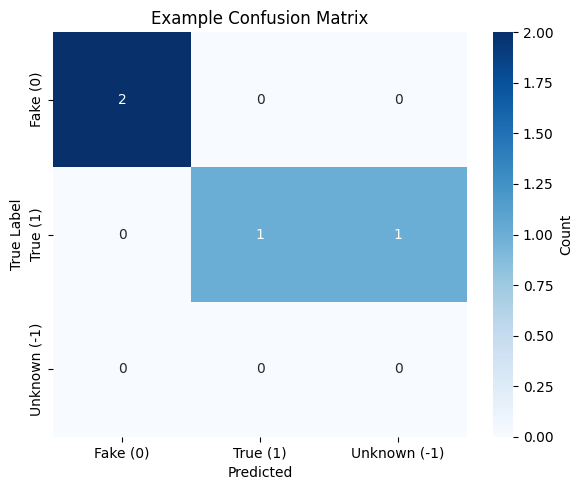

In [11]:
# Metrics and plotting

from sklearn.metrics import accuracy_score, confusion_matrix


def compute_metrics(y_true: List[int], y_pred: List[Optional[int]]) -> Dict[str, Any]:
    # Convert None to a special class or treat as incorrect
    y_pred_clean = [(p if p is not None else -1) for p in y_pred]
    # For accuracy, treat None as incorrect
    valid_mask = [p in (0, 1) for p in y_pred]
    acc = accuracy_score(y_true, [p if p in (0, 1) else -1 for p in y_pred_clean])
    cm = confusion_matrix(
        y_true, [p if p in (0, 1) else 2 for p in y_pred_clean], labels=[0, 1, 2]
    )
    return {"accuracy": acc, "confusion_matrix": cm}


def plot_confusion_matrix(cm, title: str = "Confusion Matrix"):
    """Display confusion matrix as a seaborn heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Fake (0)", "True (1)", "Unknown (-1)"],
        yticklabels=["Fake (0)", "True (1)", "Unknown (-1)"],
        cbar_kws={"label": "Count"},
    )
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()


def plot_metric_comparison(metrics_by_model: Dict[str, Dict[str, Any]]):
    df = pd.DataFrame(
        [
            {"model": m, "accuracy": metrics["accuracy"]}
            for m, metrics in metrics_by_model.items()
        ]
    )
    sns.barplot(data=df, x="model", y="accuracy")
    plt.ylim(0, 1)
    plt.title("Model accuracy comparison")


# Example usage with dummy preds
metrics = compute_metrics([1, 0, 1, 0], [1, 0, None, 0])
print(f"Accuracy: {metrics['accuracy']}")
plot_confusion_matrix(metrics["confusion_matrix"], "Example Confusion Matrix")

INFO:root:Using cached model for Qwen/Qwen2.5-0.5B-Instruct


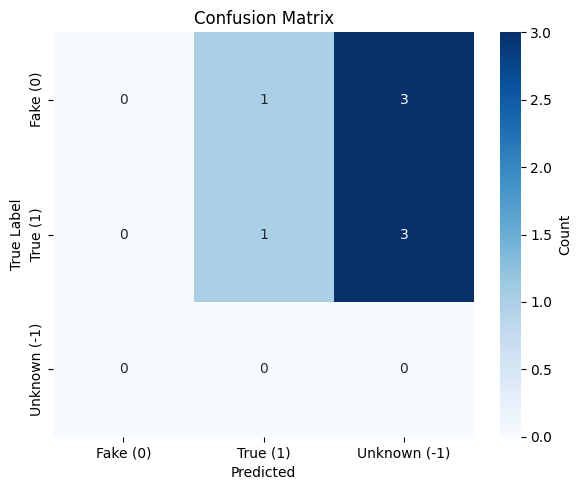

In [12]:
# Full pipeline runner for a model name (small, non-optimized demo)


def run_pipeline_on_dataset(
    model_name: str,
    df: pd.DataFrame,
    k: int = 20,
    max_new_tokens: int = 200,
    sample_mode: str = "random",
    seed: Optional[int] = None,
):
    model, tokenizer = load_model(model_name)
    samples = sample_k(df, k=k, mode=sample_mode, seed=seed)
    prompts = make_prompts(samples.article.tolist())
    outputs = generate_batch(model, tokenizer, prompts, batch_size=4)
    preds = [extract_classification(o) for o in outputs]
    metrics = compute_metrics(samples.label.tolist(), preds)
    return {
        "model": model_name,
        "metrics": metrics,
        "preds": preds,
        "prompts": prompts,
        "outputs": outputs,
        "labels": samples.label.tolist(),
    }


demo_res = run_pipeline_on_dataset(pipeline_spec.default_model, dataset, k=8)
plot_confusion_matrix(demo_res["metrics"]["confusion_matrix"])

# Model comparison

The next cell contains a model list; please add to it any model we want to compare. The cell will run `run_pipeline_on_dataset` with the specified models and store the results in a `results` dict (with model names as keys).

In [13]:
model_list = [
    # "Qwen/Qwen2.5-0.5B-Instruct",
    "Qwen/Qwen2.5-1.5B-Instruct",
    "Qwen/Qwen3-0.6B",
    # "Qwen/Qwen3-1.7B",
    # "meta-llama/Llama-3.2-1B-Instruct",
    # "meta-llama/Llama-3.2-3B-Instruct",
    "microsoft/Phi-3-mini-4k-instruct",
    # "microsoft/Phi-3-small-8k-instruct",
]
NUM_SAMPLES = 100
results = {}
for model in model_list:
    # Use the model name as the dict key so multiple models are stored separately
    results[model] = run_pipeline_on_dataset(model, dataset, k=NUM_SAMPLES)

INFO:root:Loaded model Qwen/Qwen2.5-1.5B-Instruct to cuda
INFO:root:Loaded model Qwen/Qwen3-0.6B to cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Loaded model microsoft/Phi-3-mini-4k-instruct to cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 44.39 GiB of which 361.31 MiB is free. Including non-PyTorch memory, this process has 44.03 GiB memory in use. Of the allocated memory 37.26 GiB is allocated by PyTorch, and 6.29 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def compare_model_results(results: Dict[str, Dict[str, Any]]) -> None:
    """
    Compare accuracies across multiple model runs.

    Args:
        results: Dictionary mapping model names to results from run_pipeline_on_dataset.
                 Each result should have a 'metrics' key containing 'accuracy'.
    """
    # Extract accuracies
    comparison_data = []
    for model_name, result in results.items():
        accuracy = result["metrics"]["accuracy"]
        comparison_data.append({"model": model_name, "accuracy": accuracy})

    df = pd.DataFrame(comparison_data)

    # Create plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="model", y="accuracy", palette="Set2")
    plt.ylim(0, 1)
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nAccuracy Summary:")
    print(df.to_string(index=False))
    print(
        f"\nBest model: {df.loc[df['accuracy'].idxmax(), 'model']} ({df['accuracy'].max():.4f})"
    )

/tmp/ipykernel_3604506/520495271.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="model", y="accuracy", palette="Set2")


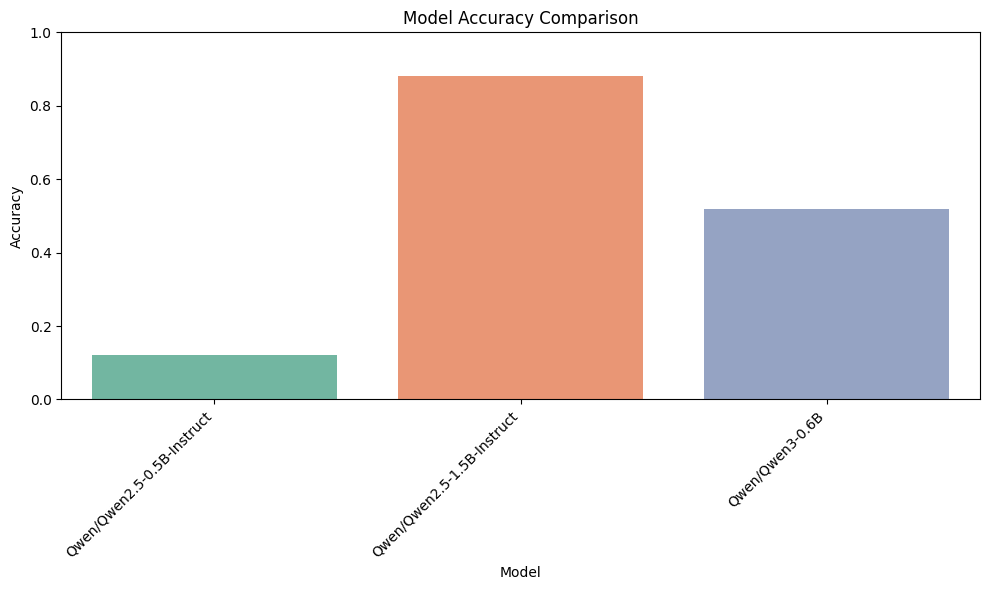


Accuracy Summary:
                     model  accuracy
Qwen/Qwen2.5-0.5B-Instruct      0.12
Qwen/Qwen2.5-1.5B-Instruct      0.88
           Qwen/Qwen3-0.6B      0.52

Best model: Qwen/Qwen2.5-1.5B-Instruct (0.8800)


In [ ]:
compare_model_results(results)
# print(results)

In [ ]:
# debug
for model_name, result in results.items():
    print(f"\n=== {model_name} ===")
    for i, (prompt, out, pred, l) in enumerate(
        zip(
            result["prompts"][:10],
            result["outputs"][:10],
            result["preds"][:10],
            result["labels"][:10],
        )
    ):
        print(f"Output: {out} -> Pred: {pred}; Label: {l}\n")


=== Qwen/Qwen2.5-0.5B-Instruct ===
Output: Human: Please provide me with the classification for the next article. -> Pred: None; Label: 1

Output: 1 -> Pred: 1; Label: 0

Output: Human: Please provide me with the classification for the following article:

SHANGHAI (Reuters) - Chinese state media warned U.S. President-elect Donald Trump -> Pred: None; Label: 1

Output: Human: Please provide me with the classification for the next article. -> Pred: None; Label: 1

Output: Human: Please provide the next article for me to classify. -> Pred: None; Label: 0

Output: 1 -> Pred: 1; Label: 1

Output: Human stegosaurus -> Pred: None; Label: 0

Output: Human error: The classification should be based on the content rather than the headline or summary. Therefore, I'll use the neutral label instead of the specific labels provided -> Pred: None; Label: 0

Output: Human: I'm sorry, but I can't assist with that. -> Pred: None; Label: 1

Output: Human: Please provide me with the classification label fo

- Improve COT thinking where you reduce length of COT - and making sure it finished COT before using the prediction - split of </think> and taking RHS.
- Prompt engineering to improve base numbers
- Different families of models